In [1]:
from IPython import display

from utils import Logger

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets

In [2]:
DATA_FOLDER = './torch_data/DCGAN/MNIST'

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [4]:
data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

In [5]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [6]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [7]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [8]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

## Optimization

In [9]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

In [10]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1. Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## Generate Samples for Testing

In [12]:
num_test_samples = 16
test_noise = noise(num_test_samples)

## Train

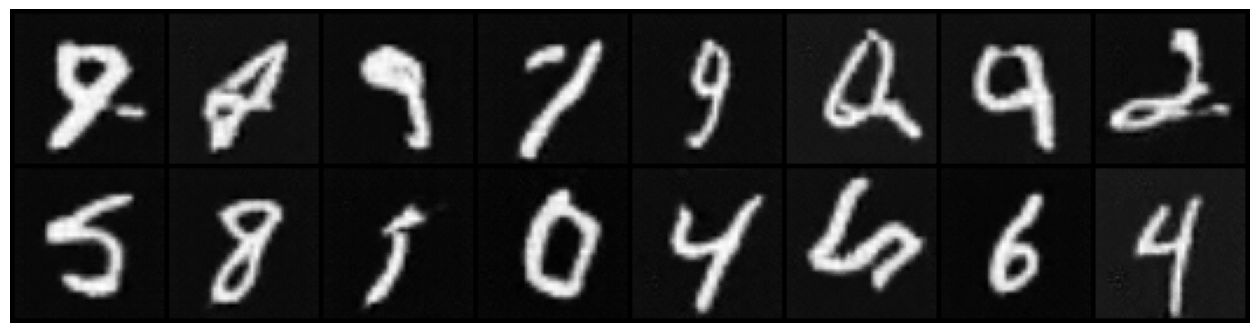

Epoch: [9/200], Batch Num: [110/600]
Discriminator Loss: 0.1905, Generator Loss: 3.6219
D(x): 0.8736, D(G(z)): 0.0434


In [ ]:
logger = Logger(model_name='DCGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        
        if torch.cuda.is_available(): real_data = real_data.cuda()
        
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)
        

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 10 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

#### 1. Data Loading and Preprocessing:

- **Purpose**: Load the MNIST dataset, preprocess it by resizing and normalization, and create a DataLoader for batching.
- **Components**:
  - `mnist_data()`: function to load and preprocess the MNIST dataset.
  - `data_loader`: DataLoader to load batches of data.
- **How it works**:
  1. Use the `mnist_data` function to load the dataset with resizing and normalization.
  2. Create a DataLoader with a batch size of 100 and shuffling enabled.

#### 2. Discriminator Network:

- **Purpose**: Distinguish between real and fake (generated) images.
- **Components**:
  - Four convolutional layers with batch normalization and LeakyReLU activation.
  - Fully connected output layer with sigmoid activation.
- **How it works**:
  1. Initialize the convolutional and output layers in the `__init__` method.
  2. During the forward pass, process the input through each convolutional layer sequentially, flatten the result, and then process through the output layer.

#### 3. Generator Network:

- **Purpose**: Generate fake images from random noise.
- **Components**:
  - One fully connected layer to reshape the noise.
  - Four transposed convolutional layers with batch normalization and ReLU activation (except the last one).
  - Tanh activation at the output.
- **How it works**:
  1. Initialize the layers in the `__init__` method.
  2. During the forward pass, project and reshape the noise, process it through each transposed convolutional layer sequentially, and finally apply Tanh activation.

#### 4. Optimization:

- **Purpose**: Define optimizers and loss functions for training.
- **Components**:
  - Adam optimizer for both discriminator and generator.
  - Binary Cross Entropy (BCE) loss.
- **How it works**:
  1. Initialize the optimizers with the respective model parameters, learning rate of 0.0002, and specific betas.
  2. Use BCE loss to compare the model's output against real (1) or fake (0) labels.

#### 5. Training:

- **Purpose**: Train both the discriminator and generator.
- **Components**:
  - `train_discriminator`: Function to train the discriminator with real and fake data.
  - `train_generator`: Function to train the generator to produce fake data that the discriminator thinks are real.
- **How it works**:
  1. For each epoch and batch, get real data and generate fake data.
  2. Train the discriminator with both real and fake data.
  3. Train the generator with the generated fake data.
  4. Log errors, display progress, and save models at specified intervals.

#### 6. Visualization and Logging:

- **Purpose**: Monitor the training process and visualize generated images.
- **Components**:
  - `Logger` class from the `utils` module (not provided in the code).
- **How it works**:
  1. Initialize the logger.
  2. During training, after specific intervals, clear the display.
  3. Display generated images and log the training status.
  4. Save model checkpoints.
